In [38]:
import json
from collections import Counter
from dataclasses import dataclass

import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from einops import rearrange
from kmeans_pytorch import kmeans

In [28]:
%load_ext autoreload

In [29]:
%autoreload 2

In [30]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE, SlideMAEV2

In [31]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [76]:
slide_order = metadata['slices']

In [49]:
scale = .1

In [36]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='[0-9].h5ad$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s3.h5ad']

In [39]:
pct_expression = .02
pool = []
for fp in fps:
    a = sc.read_h5ad(fp)
    
    spot_count = (a.X.toarray()>0).sum(0)
    mask = spot_count > pct_expression * a.shape[0]
    a = a[:, mask]

    pool += a.var.index.to_list()
counts = Counter(pool)
channels = sorted([c for c, count in counts.items() if count==len(fps)])
len(channels), channels[:5]

(11630, ['A1BG', 'A2M', 'A4GALT', 'AAAS', 'AACS'])

In [42]:
slide_to_visium = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.h5ad', '')
    a = sc.read_h5ad(fp)
    label_to_barcode = {i+1:x for i, x in enumerate(a.obs.index)}
    barcode_to_label = {v:k for k, v in label_to_barcode.items()}
    a.uns['label_to_barcode'] = label_to_barcode
    a.uns['barcode_to_label'] = barcode_to_label
    
    a = a[:, channels]
    sc.pp.log1p(a)
    
    slide_to_visium[sample] = a
slide_to_visium.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


dict_keys(['s0', 's3'])

In [43]:
visium_channels = list(channels)

In [44]:
a = next(iter(slide_to_visium.values()))
a

AnnData object with n_obs × n_vars = 3058 × 11630
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

In [45]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [46]:
pool = []
for fp in fps:
    channels = utils.get_ome_tiff_channels(fp)
    channels = [utils.R_CHANNEL_MAPPING.get(c, c) for c in channels]
    pool += channels
Counter(pool).most_common()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


[('Bap1', 4),
 ('CD31', 4),
 ('CD45', 4),
 ('CD68', 4),
 ('CD8', 4),
 ('CK19', 4),
 ('COX6c', 4),
 ('DAPI', 4),
 ('ER', 4),
 ('FOXP3', 4),
 ('GATA3', 4),
 ('GLUT1', 4),
 ('HLA-DR', 4),
 ('Her2', 4),
 ('CK14', 4),
 ('Ki67', 4),
 ('MGP', 4),
 ('PLAT/tPA', 4),
 ('PR', 4),
 ('Pan-Cytokeratin', 4),
 ('Podoplanin', 4),
 ('SMA', 4),
 ('Vimentin', 4),
 ('cKit', 4),
 ('CD20', 2),
 ('CD3e', 2),
 ('CD11b', 1),
 ('E-cadherin', 1)]

In [47]:
channels = sorted([c for c, count in Counter(pool).items() if count==len(fps)])
channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [50]:
slide_to_multiplex = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.ome.tiff', '')
    cs, img = utils.extract_ome_tiff(fp, as_dict=False)
    img = torch.tensor(img)
    thumbnail = TF.resize(img, (int(scale * img.shape[-2]), int(scale * img.shape[-1])))
    thumbnail = thumbnail.to(torch.float32)
    
    cs = [utils.R_CHANNEL_MAPPING[c] for c in cs]
    idxs = [cs.index(c) for c in channels]
    thumbnail = thumbnail[idxs]
    
    slide_to_multiplex[sample] = thumbnail

In [51]:
multiplex_channels = list(channels)

In [52]:
slide_to_data = {k:v for k, v in slide_to_visium.items()}
slide_to_data.update(slide_to_multiplex)
slide_to_data.keys()

dict_keys(['s0', 's3', 's1', 's2', 's4', 's5'])

In [53]:
slide_to_dtype = {s:'visium' for s in slide_to_visium.keys()}
slide_to_dtype.update({s:'multiplex' for s in slide_to_multiplex.keys()})
slide_to_dtype

{'s0': 'visium',
 's3': 'visium',
 's1': 'multiplex',
 's2': 'multiplex',
 's4': 'multiplex',
 's5': 'multiplex'}

In [54]:
samples = sorted(slide_to_data.keys())
samples

['s0', 's1', 's2', 's3', 's4', 's5']

In [66]:
def format_expression(tiles, adatas, patch_size):
    # add batch dim if there is none
    if len(tiles.shape) == 2:
        tiles = tiles.unsqueeze(0)
    if isinstance(adatas, anndata.AnnData):
        adatas = [adatas]
    
    exp_imgs = []
    for tile, adata in zip(tiles, adatas):
        tile = rearrange(tile, '(ph h) (pw w) -> h w (ph pw)', ph=patch_size, pw=patch_size)
        x = torch.unique(tile, dim=-1)

        exp = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], dtype=torch.float32)
        l2b = adata.uns['label_to_barcode']
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                labels = x[i, j]
                labels = labels[labels!=0]
                if len(labels):
                    barcodes = [l2b[l.item()] for l in labels]
                    exp[i, j] = torch.tensor(adata[barcodes].X.mean(0))
        exp = rearrange(exp, 'h w c -> c h w')
        exp_imgs.append(exp)
    
    return torch.stack(exp_imgs)

def get_slide_to_labeled(slide_to_adata, crop=True, scale=.1):
    slide_to_labeled = {}
    for s, a in slide_to_adata.items():
        a.obsm['spatial_scaled'] = (a.obsm['spatial'] * scale).astype(np.int32)
        labeled_locations = np.zeros(
            (np.asarray(a.uns['he_rescaled_warped'].shape[:2]) * scale).astype(int), dtype=int)
        for barcode, (c, r) in zip(a.obs.index, a.obsm['spatial_scaled']):
            labeled_locations[r, c] = a.uns['barcode_to_label'][barcode]

        if crop:
            min_c, min_r = a.obsm['spatial_scaled'].min(0)
            max_c, max_r = a.obsm['spatial_scaled'].max(0)
        else:
            min_r, min_c = 0, 0
            max_r, max_c = labeled_locations.shape
        labeled_locations = labeled_locations[min_r:max_r, min_c:max_c]
        slide_to_labeled[s] = torch.tensor(labeled_locations)
    return slide_to_labeled

In [67]:
class InferenceTransform(object):
    def __init__(self, normalize=None):
        self.transforms = Compose([
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class InferenceTransformVisium(object):
    def __init__(self, size=(256, 256), patch_size=32, normalize=None):
        self.size = size
        self.patch_size = patch_size
        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, adata):
        tile = x.squeeze()
        tile = format_expression(tile, adata, patch_size=self.patch_size)
        tile = self.normalize(tile)
        return tile


class InferenceSlideDataset(Dataset):
    def __init__(self, slide_to_img, size=(256, 256), transform=None):
        """"""
        self.size = size
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x) for s, x in self.slide_to_img.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x, size=None):
        size = self.size if size is None else size
        pad_h, pad_w = size[-2] - x.shape[-2] % size[-2], size[-1] - x.shape[-1] % size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, size[-2], size[-2] // 2)
        x = x.unfold(-2, size[-1], size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        return rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
    
    def slide_from_tiles(self, x, slide_idx, size=None):
        """
        x - (n c h w)
        """
        size = self.size if size is None else size
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
        
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx])
        }
    
class InferenceSlideDatasetVisium(Dataset):
    def __init__(self, slide_to_adata, size=(256, 256), transform=None, crop=False, scale=.1):
        """"""
        self.size = size
        self.scale = scale
        self.slides = sorted(slide_to_adata.keys())
        self.slide_to_adata = slide_to_adata
        
        self.slide_to_labeled = get_slide_to_labeled(slide_to_adata, crop=crop, scale=scale)
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x.unsqueeze(0)) for s, x in self.slide_to_labeled.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x):
        pad_h, pad_w = self.size[-2] - x.shape[-2] % self.size[-2], self.size[-1] - x.shape[-1] % self.size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, self.size[-2], self.size[-2] // 2)
        x = x.unfold(-2, self.size[-1], self.size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x, to_expression=False, adata=None):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        
        if to_expression:
            ps = self.transform.patch_size
            new = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], x.shape[-2] // ps, x.shape[-1] // ps,
                             dtype=torch.float32)
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    new[i, j] = format_expression(x[i, j, 0], adata, ps)
            x = new
        x = rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
        return x
        
    
    def slide_from_tiles(self, x, slide_idx, size=None):
        """
        x - (n c h w)
        """
        size = size if size is not None else self.size
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
            
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx], self.slide_to_adata[slide])
        }

In [102]:
size = (256, 256)

# used for reconstruction functionality
inference_ds_multiplex = InferenceSlideDataset(
    {k:v for k, v in slide_to_data.items() if slide_to_dtype[k]=='multiplex'},
    transform=None)

In [103]:
transform = InferenceTransformVisium(size=(256, 256), patch_size=32, normalize=None)
inference_ds_visium = InferenceSlideDatasetVisium(
    {k:v for k, v in slide_to_data.items() if slide_to_dtype[k]=='visium'},
    size=size, transform=transform, crop=False)

In [114]:
recon_multi = torch.stack(
    [inference_ds_multiplex.image_from_tiles(inference_ds_multiplex.slide_to_tiles[s])
    for s in inference_ds_multiplex.slides]
)
recon_multi = TF.resize(recon_multi, (52, 52))
recon_multi.shape

torch.Size([4, 24, 52, 52])

In [115]:
recon_visium = torch.stack(
    [inference_ds_visium.image_from_tiles(
        inference_ds_visium.slide_to_tiles[s],
        to_expression=True, adata=inference_ds_visium.slide_to_adata[s])
    for s in inference_ds_visium.slides]
)
recon_visium.shape

torch.Size([2, 11630, 52, 52])

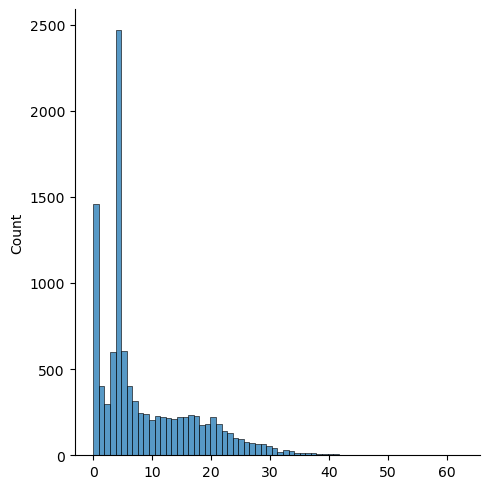

In [172]:
blurred_multi = TF.gaussian_blur(recon_multi, [3, 3])
sns.displot(blurred_multi[:, multiplex_channels.index('DAPI')].flatten().numpy())

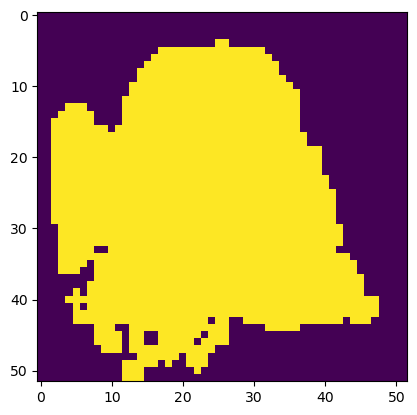

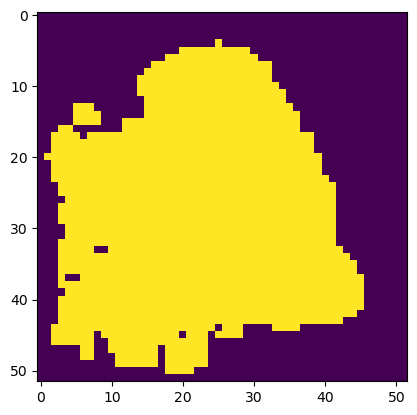

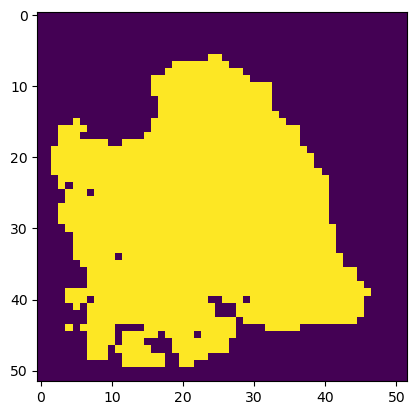

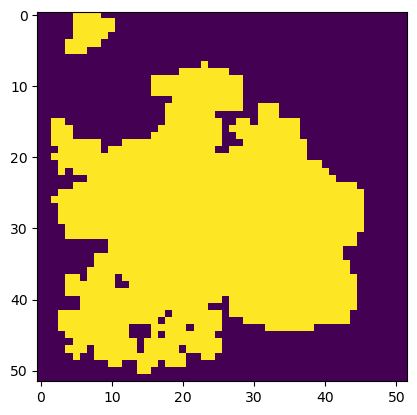

In [173]:
multiplex_masks = blurred_multi[:, multiplex_channels.index('DAPI')] > 5
for mask in multiplex_masks:
    plt.imshow(mask)
    plt.show()

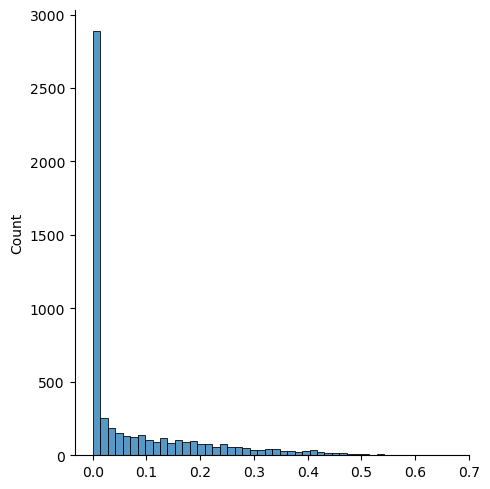

In [174]:
blurred_visium = TF.gaussian_blur(recon_visium, [3, 3])
sns.displot(blurred_visium.mean(dim=1).flatten().numpy())

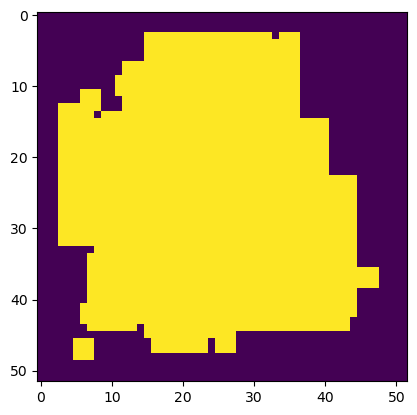

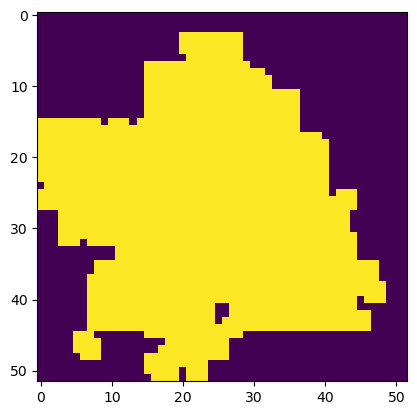

In [175]:
visium_masks = blurred_visium.mean(dim=1) > 0.
for mask in visium_masks:
    plt.imshow(mask)
    plt.show()

In [176]:
multiplex_masks.shape, visium_masks.shape

(torch.Size([4, 52, 52]), torch.Size([2, 52, 52]))

In [32]:
multiplex_embs = torch.load('../data/mae_v4/outputs.pt')
visium_embs = torch.load('../data/mae_v5/outputs.pt')

In [34]:
multiplex_embs.keys(), visium_embs.keys()

(dict_keys(['encoded_tokens', 'decoded_tokens', 'predicted_patches', 'idx_to_coord']),
 dict_keys(['encoded_tokens', 'decoded_tokens', 'predicted_patches', 'idx_to_coord']))

In [164]:
multiplex_embs['encoded_tokens'].shape, visium_embs['encoded_tokens'].shape

(torch.Size([676, 8, 8, 1024]), torch.Size([338, 8, 8, 1024]))

In [170]:
recon_multi_embs = torch.stack(
    [inference_ds_multiplex.slide_from_tiles(
        rearrange(multiplex_embs['encoded_tokens'], 'n h w c -> n c h w'),
        i, size=(8, 8))
    for i in range(len(inference_ds_multiplex.slides))]
)
recon_multi_embs = rearrange(recon_multi_embs, 'b c h w -> b h w c')
recon_multi_embs.shape

torch.Size([4, 52, 52, 1024])

In [171]:
recon_visium_embs = torch.stack(
    [inference_ds_visium.slide_from_tiles(
        rearrange(visium_embs['encoded_tokens'], 'n h w c -> n c h w'),
        i, size=(8, 8))
    for i in range(len(inference_ds_visium.slides))]
)
recon_visium_embs = rearrange(recon_visium_embs, 'b c h w -> b h w c')
recon_visium_embs.shape

torch.Size([2, 52, 52, 1024])

###### regress out background and coordinate position

In [233]:
multiplex_embs['encoded_tokens'].shape

torch.Size([676, 8, 8, 1024])

In [234]:
target = recon_multi_embs.numpy()
target.shape

(4, 52, 52, 1024)

In [235]:
X_background = multiplex_masks.clone().to(torch.long).unsqueeze(-1)
X_background.shape

torch.Size([4, 52, 52, 1])

In [236]:
rc = torch.zeros(multiplex_embs['encoded_tokens'].shape[:-1], dtype=torch.long)
print(rc.shape)
idx_to_var = [(r, c) for r in range(rc.shape[1]) for c in range(rc.shape[2])]
var_to_idx = {v:i for i, v in enumerate(idx_to_var)}
for i, (slide_idx, row_idx, col_idx) in enumerate(multiplex_embs['idx_to_coord']):
    for r in range(rc.shape[1]):
        for c in range(rc.shape[2]):
            rc[i, r, c] = var_to_idx[(r, c)]
hots = torch.nn.functional.one_hot(rc)

X_coords = torch.stack(
    [inference_ds_multiplex.slide_from_tiles(
        rearrange(hots, 'n h w c -> n c h w'),
        i, size=(8, 8))
    for i in range(len(inference_ds_multiplex.slides))]
)
X_coords = rearrange(X_coords, 'b c h w -> b h w c')
X_coords.shape

torch.Size([676, 8, 8])


torch.Size([4, 52, 52, 64])

In [237]:
X_slides = repeat(torch.arange(multiplex_masks.shape[0]), 'b -> b h w', h=52, w=52)
X_slides = torch.nn.functional.one_hot(X_slides)
X_slides.shape


torch.Size([4, 52, 52, 4])

In [238]:
X = torch.cat((X_background, X_coords, X_slides), dim=-1)
X = X.numpy()
X.shape

(4, 52, 52, 69)

In [239]:
target.shape, X.shape

((4, 52, 52, 1024), (4, 52, 52, 69))

In [240]:
target = rearrange(target, 'b h w c -> (b h w) c')
X = rearrange(X, 'b h w c -> (b h w) c')
target.shape, X.shape

((10816, 1024), (10816, 69))

In [241]:
lm = LinearRegression()
lm.fit(X, target)
residuals = lm.predict(X) - target
multi_embs_regressed = rearrange(residuals, '(b h w) c -> b h w c', b=4, h=52, w=52)
multi_embs_regressed.shape

(4, 52, 52, 1024)

In [242]:
d = {
    'encoded_tokens': recon_multi_embs,
    'encoded_tokens_regressed': torch.tensor(multi_embs_regressed),
}
torch.save(d, '../data/mae_v10/multiplex_embs.pt')

In [243]:
target = recon_visium_embs.numpy()
target.shape

(2, 52, 52, 1024)

In [244]:
X_background = visium_masks.clone().to(torch.long).unsqueeze(-1)
X_background.shape

torch.Size([2, 52, 52, 1])

In [245]:
rc = torch.zeros(visium_embs['encoded_tokens'].shape[:-1], dtype=torch.long)
print(rc.shape)
idx_to_var = [(r, c) for r in range(rc.shape[1]) for c in range(rc.shape[2])]
var_to_idx = {v:i for i, v in enumerate(idx_to_var)}
for i, (slide_idx, row_idx, col_idx) in enumerate(visium_embs['idx_to_coord']):
    for r in range(rc.shape[1]):
        for c in range(rc.shape[2]):
            rc[i, r, c] = var_to_idx[(r, c)]
hots = torch.nn.functional.one_hot(rc)

X_coords = torch.stack(
    [inference_ds_visium.slide_from_tiles(
        rearrange(hots, 'n h w c -> n c h w'),
        i, size=(8, 8))
    for i in range(len(inference_ds_visium.slides))]
)
X_coords = rearrange(X_coords, 'b c h w -> b h w c')
X_coords.shape

torch.Size([338, 8, 8])


torch.Size([2, 52, 52, 64])

In [246]:
X_slides = repeat(torch.arange(visium_masks.shape[0]), 'b -> b h w', h=52, w=52)
X_slides = torch.nn.functional.one_hot(X_slides)
X_slides.shape


torch.Size([2, 52, 52, 2])

In [247]:
X = torch.cat((X_background, X_coords, X_slides), dim=-1)
X = X.numpy()
X.shape

(2, 52, 52, 67)

In [248]:
target = rearrange(target, 'b h w c -> (b h w) c')
X = rearrange(X, 'b h w c -> (b h w) c')
target.shape, X.shape

((5408, 1024), (5408, 67))

In [249]:
lm = LinearRegression()
lm.fit(X, target)
residuals = lm.predict(X) - target
visium_embs_regressed = rearrange(residuals, '(b h w) c -> b h w c', b=2, h=52, w=52)
visium_embs_regressed.shape

(2, 52, 52, 1024)

In [250]:
d = {
    'encoded_tokens': recon_visium_embs,
    'encoded_tokens_regressed': torch.tensor(visium_embs_regressed),
}
torch.save(d, '../data/mae_v10/visium_embs.pt')

In [257]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

###### multiplex only, unsupervised

In [690]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [691]:
tokens = torch.load('../data/mae_v10/multiplex_embs.pt')['encoded_tokens_regressed']
tokens.shape

torch.Size([4, 52, 52, 1024])

In [698]:
n_clusters = 10
clusterer = KMeans(n_clusters=n_clusters)

In [699]:
# x = rearrange(tokens, 'b h w d -> (b h w) d').numpy()
x = tokens[multiplex_masks].numpy()
clusterer.fit(x)
dists = clusterer.transform(rearrange(tokens, 'b h w d -> (b h w) d').numpy())
cluster_ids = torch.tensor(dists.argmin(1))
cluster_ids.shape

torch.Size([10816])

In [700]:
cluster_ids = rearrange(cluster_ids, '(b h w) -> b h w', b=4, h=52, w=52)
dists = rearrange(torch.tensor(dists), '(b h w) d -> b h w d', b=4, h=52, w=52)
cluster_ids.shape

torch.Size([4, 52, 52])

In [701]:
cluster_ids[~multiplex_masks] = cluster_ids.max() + 1
dists[~multiplex_masks] = dists.amax((0, 1, 2))

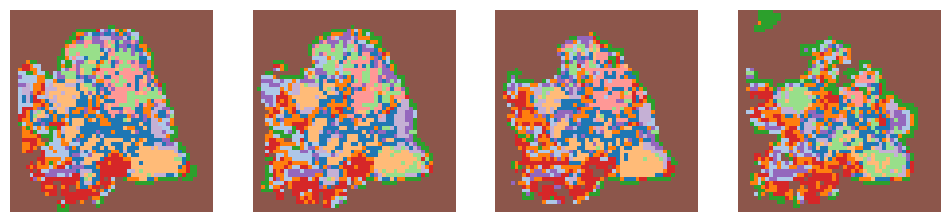

In [702]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=cluster_ids.shape[0], figsize=(12, 6))
for i, labeled in enumerate(cluster_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].axis('off')

In [703]:
labeled = cluster_ids[0]
labeled.shape

torch.Size([52, 52])

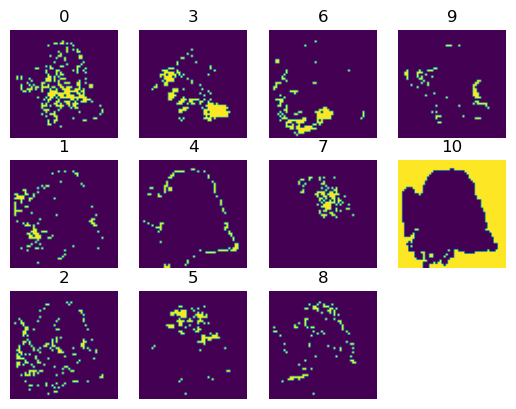

In [716]:

ncols = 4
nrows = (n_clusters + 1) // ncols + 1
    
coords = np.stack(np.meshgrid(np.arange(nrows), np.arange(ncols)))
coords = rearrange(coords, 'd h w -> (h w) d')
# coords = coords[:, [1, 0]]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i, (r, c) in zip(range(n_clusters + 1), coords):
    m = labeled==i
    axs[r, c].imshow(m)
    axs[r, c].set_title(i)

for ax in axs.flatten():
    ax.axis('off')
    

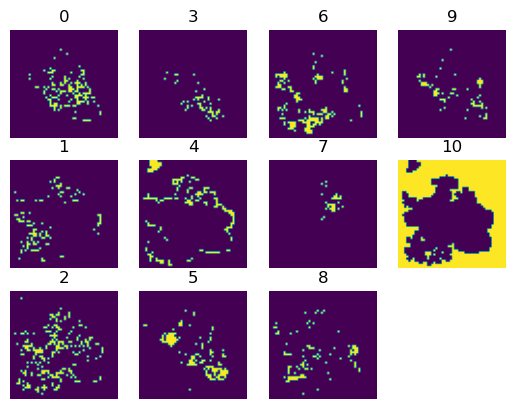

In [717]:
labeled = cluster_ids[-1]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i, (r, c) in zip(range(n_clusters + 1), coords):
    m = labeled==i
    axs[r, c].imshow(m)
    axs[r, c].set_title(i)

for ax in axs.flatten():
    ax.axis('off')

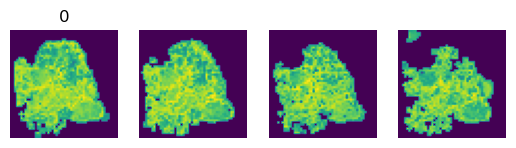

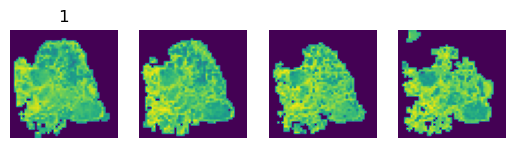

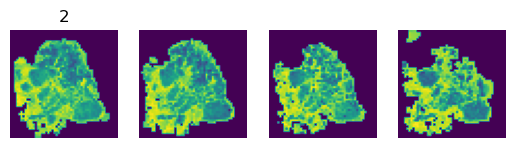

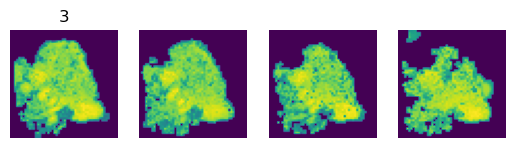

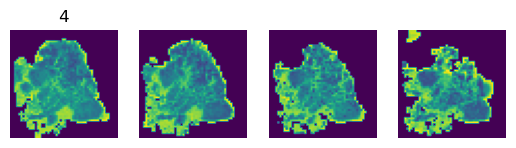

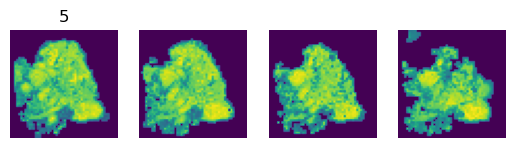

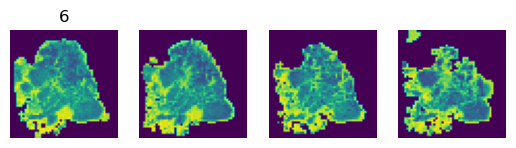

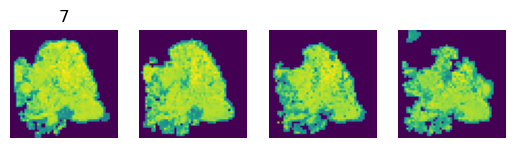

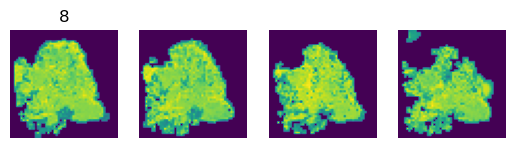

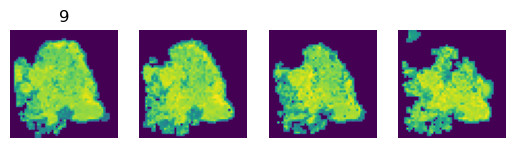

In [706]:
for c in range(n_clusters):
    fig, axs = plt.subplots(ncols=dists.shape[0])
    for i, (img, ax) in enumerate(zip(dists[..., c], axs)):
        ax.imshow(img, cmap='viridis_r')
        ax.axis('off')
    axs[0].set_title(c, rotation=0)
    plt.show()

In [707]:
locations = np.asarray([2, 12, 22, 31])
locations -= locations.min()
locations

array([ 0, 10, 20, 29])

In [708]:
from torchio.transforms import Resize

In [719]:
scaler = 10.

In [721]:
dist_volume = torch.zeros(locations.max(), dists.shape[3], int(dists.shape[1] * scaler), int(dists.shape[2] * scaler))
for i in range(dists.shape[0] - 1):
    l1, l2 = locations[i], locations[i+1]
    stack = rearrange(dists[i:i+2], 'b h w c -> c b h w')
    transform = Resize((l2 - l1, int(stack.shape[-2] * scaler), int(stack.shape[-1] * scaler)))
    out = transform(stack)
    dist_volume[l1:l2] = rearrange(out, 'c b h w -> b c h w')
dist_volume.shape

torch.Size([29, 10, 520, 520])

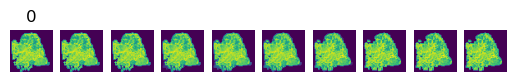

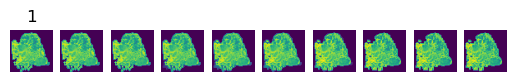

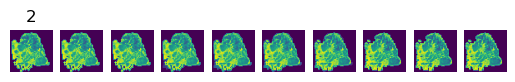

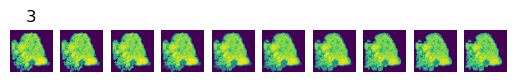

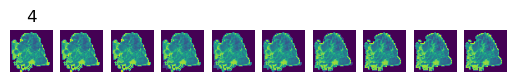

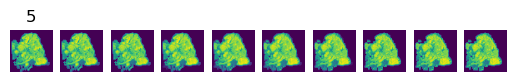

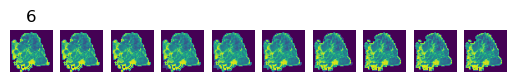

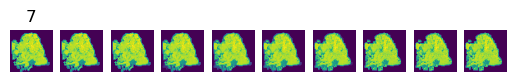

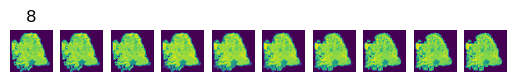

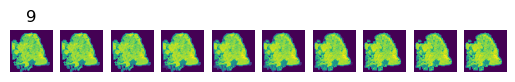

In [710]:
for c in range(n_clusters):
    fig, axs = plt.subplots(ncols=dist_volume.shape[1])
    for i, (img, ax) in enumerate(zip(dist_volume[:, c, ...], axs)):
        ax.imshow(img, cmap='viridis_r')
        ax.axis('off')
    axs[0].set_title(c, rotation=0)
    plt.show()

In [722]:
to_save = dist_volume.max() - dist_volume
to_save /= to_save.max()
to_save *= 255.
to_save = to_save.to(torch.uint8).numpy()
to_save.shape

(29, 10, 520, 520)

In [712]:
from tifffile import TiffWriter

In [713]:
x = rearrange(to_save, 't c h w -> t c h w 1')
x.shape

(29, 10, 52, 52, 1)

In [714]:
out_fp = '../data/mae_v10/multiplex_cluster_distance.ome.tif'
print(data.shape)
pixelsize = 100  # micrometer
with TiffWriter(out_fp, bigtiff=True) as tif:
    metadata={
        'axes': 'TCYXS',
        'Channel': {'Name': [f'Cluster {i}' for i in range(data.shape[1])]},
    }
    tif.write(
        x,
#         resolution=(1e4 / pixelsize, 1e4 / pixelsize),
        metadata=metadata,
    )

(20, 24)


In [715]:
import tifffile

In [642]:
tifffile.imsave('../data/mae_v10/cluster_19.tif', x[:, 19, :, :, 0])

In [643]:
z = x[:, 19, :, :, 0]
z.shape

(29, 52, 52)

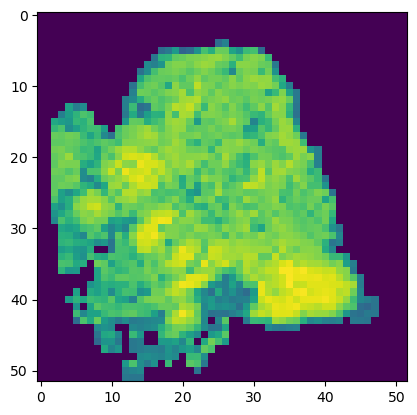

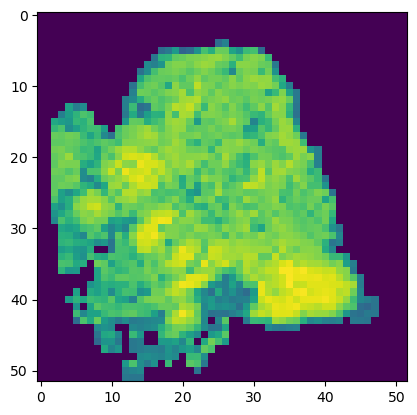

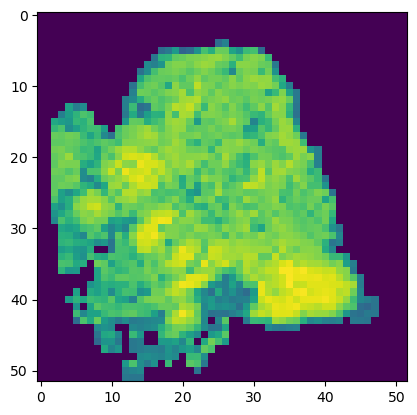

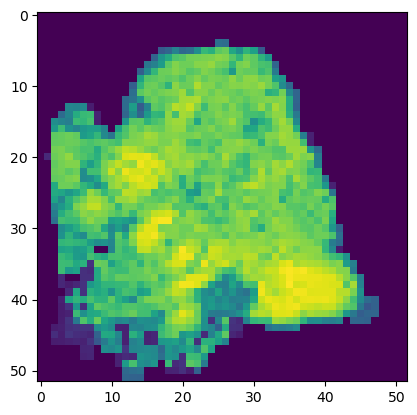

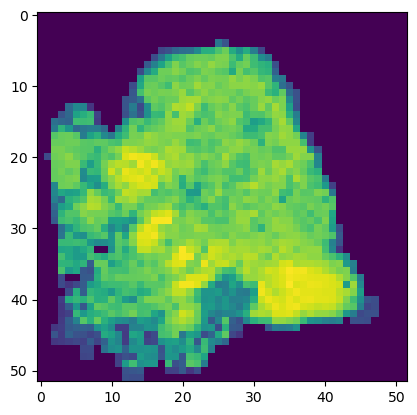

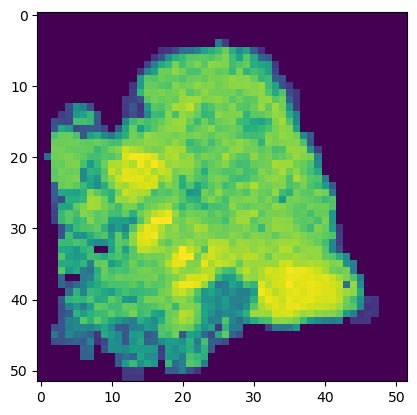

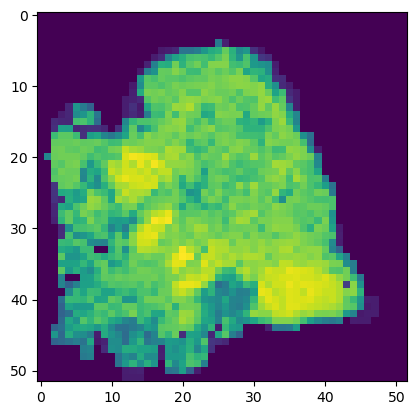

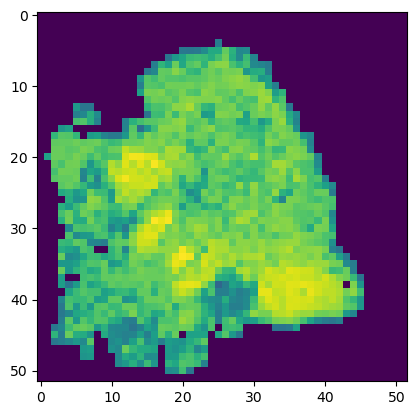

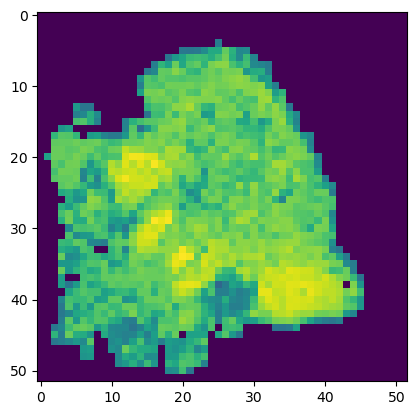

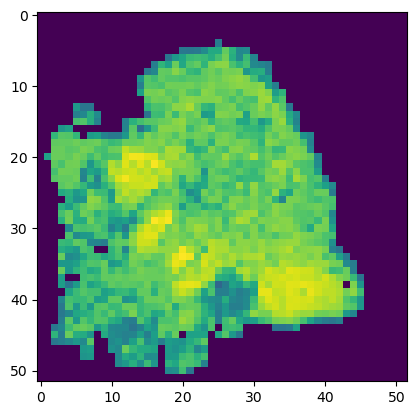

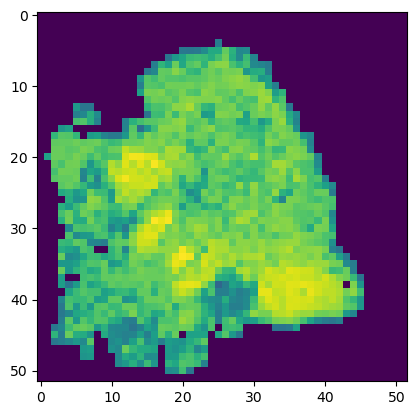

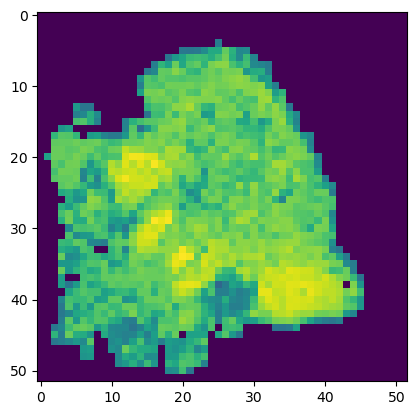

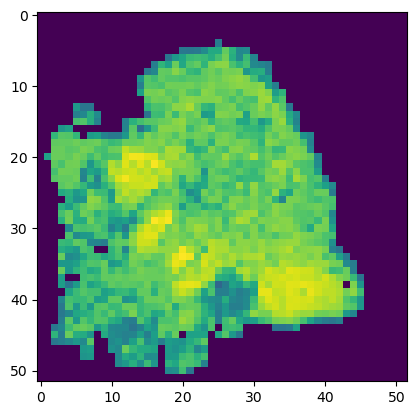

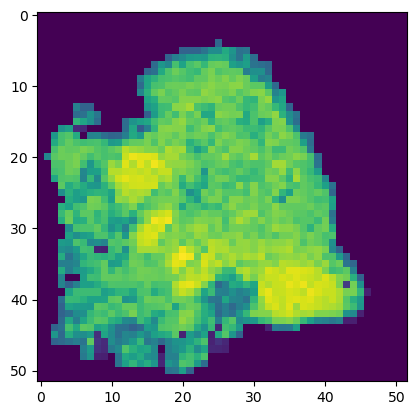

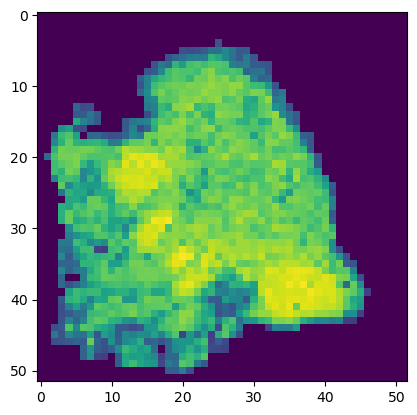

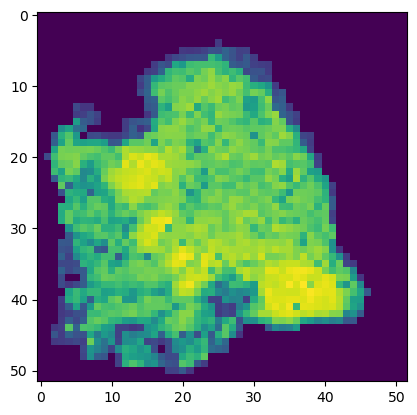

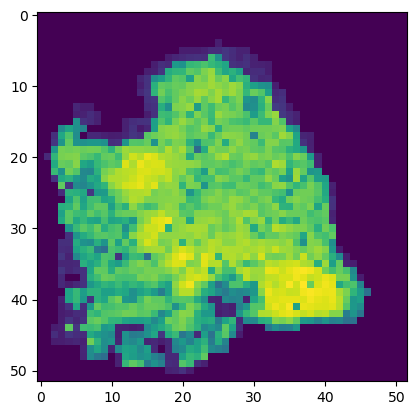

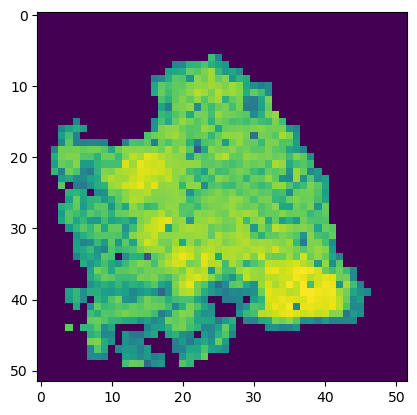

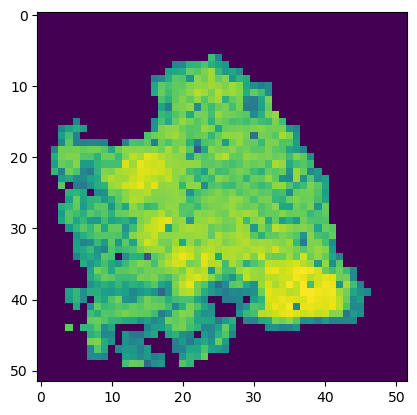

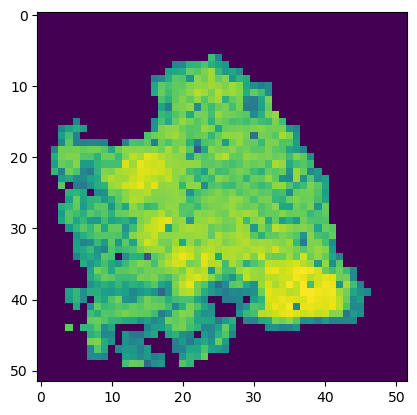

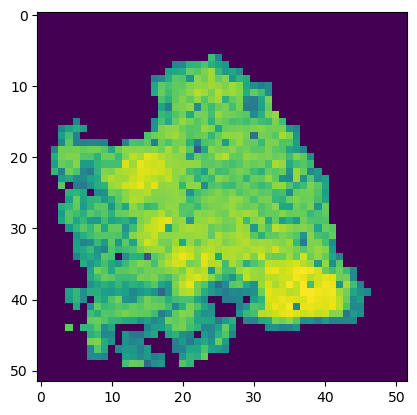

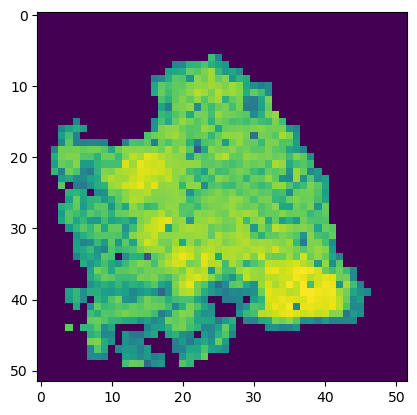

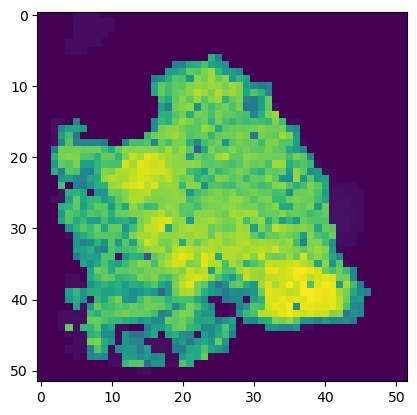

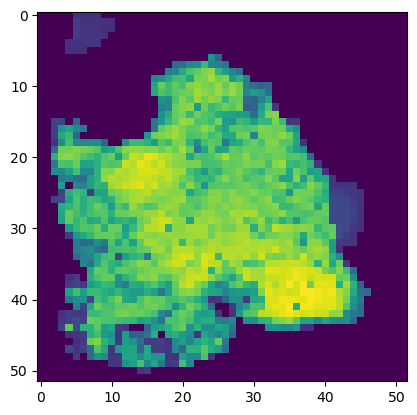

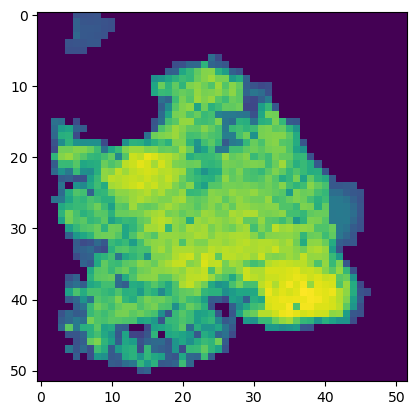

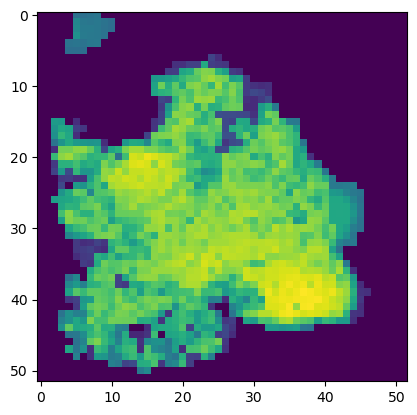

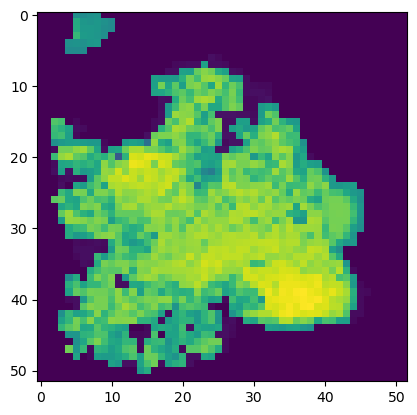

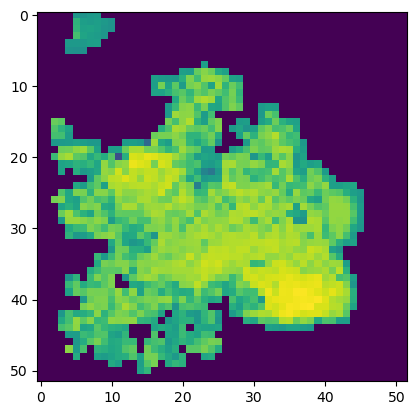

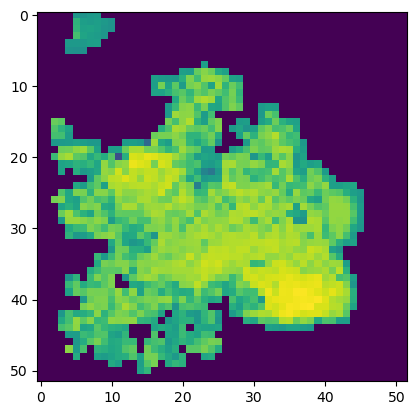

In [644]:
for img in z:
    plt.imshow(img)
    plt.show()

In [646]:
# cluster associations with channels
dists.shape

torch.Size([4, 52, 52, 20])

In [648]:
x = rearrange(recon_multi, 'b c h w -> b h w c')
x.shape

torch.Size([4, 52, 52, 24])

In [655]:
from scipy.stats import pearsonr
import pandas as pd

In [664]:
# data = np.zeros((dists.shape[-1], x.shape[-1]))
# dists_inv = dists.max() - dists
# for cluster in range(dists.shape[-1]):
#     for channel in range(x.shape[-1]):
#         data[cluster, channel] = pearsonr(
#             dists_inv[..., cluster].numpy().flatten(),
#             x[..., channel].numpy().flatten()
#         )[0]
# corr_df = pd.DataFrame(data=data, columns=multiplex_channels)
# corr_df

In [665]:

# sns.clustermap(corr_df, figsize=(15, 15))

In [679]:
# data = np.zeros((dists.shape[-1], x.shape[-1]))
# dists_inv = dists.max() - dists
data = []
for cluster in range(dists.shape[-1]):
    data.append(x[cluster_ids==cluster].mean(0).numpy())
data = np.vstack(data)
df = pd.DataFrame(data=data, columns=multiplex_channels)
df

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,0.123223,2.131517,3.494076,0.343602,0.116114,3.808057,22.382702,0.849526,17.913507,8.816351,...,0.526066,1.817536,9.270143,5.515403,11.780806,54.646919,0.452607,13.742891,41.207348,0.808057
1,0.014113,0.018817,0.169355,0.039651,0.165323,0.976479,0.549731,0.028226,4.690188,0.013441,...,0.008065,0.012769,2.151882,0.151210,0.254704,2.192204,0.179435,0.439516,1.547043,0.300403
2,0.044444,1.347222,2.749074,0.100000,0.450926,0.360185,1.912963,0.416667,14.043518,2.832407,...,0.093519,0.537037,4.802778,2.482407,7.884259,8.115741,0.208333,5.663889,37.879631,0.566667
3,0.030242,0.698253,0.544355,0.039651,0.112231,0.586021,0.619624,0.172715,6.865592,0.602151,...,0.033602,0.183468,2.806452,1.111559,4.987903,2.325941,0.127688,2.274194,25.651882,0.221102
4,0.275610,1.654878,7.014634,0.447561,0.620732,0.503659,50.806099,1.923171,22.014635,9.479268,...,0.936585,7.042683,10.176829,7.993902,20.801220,97.896339,0.220732,4.810976,27.347561,1.713415
5,0.091153,3.878016,4.859920,0.186997,1.489276,0.521448,4.076407,0.766086,19.110590,6.766756,...,0.226542,1.883378,7.122654,4.264075,10.027480,13.323727,0.612601,11.254022,65.696381,0.648123
6,0.148352,2.238095,4.457875,0.319597,0.440476,1.065934,20.021063,0.893773,19.481686,7.887362,...,0.389194,2.633700,8.764652,5.040293,11.142858,50.732601,0.404762,10.150183,39.764652,0.780220
7,0.176991,2.005531,3.439159,0.316372,0.057522,20.186947,18.189159,1.159292,18.325222,8.696902,...,0.539823,4.274336,13.997787,7.198009,10.550885,58.174778,1.116150,36.733406,50.348450,0.806416
8,0.030397,1.070099,0.849876,0.050248,0.289702,0.749380,1.398883,0.250620,9.112283,1.384615,...,0.055211,0.689826,4.116625,1.459677,9.467742,5.145782,0.172457,5.014268,26.302729,0.431762
9,0.062222,1.010000,1.110000,0.136667,0.190000,1.881111,8.525556,0.433333,10.970000,1.712222,...,0.125556,0.921111,4.736667,2.225556,9.801111,22.832222,0.295556,3.974444,14.217778,0.660000


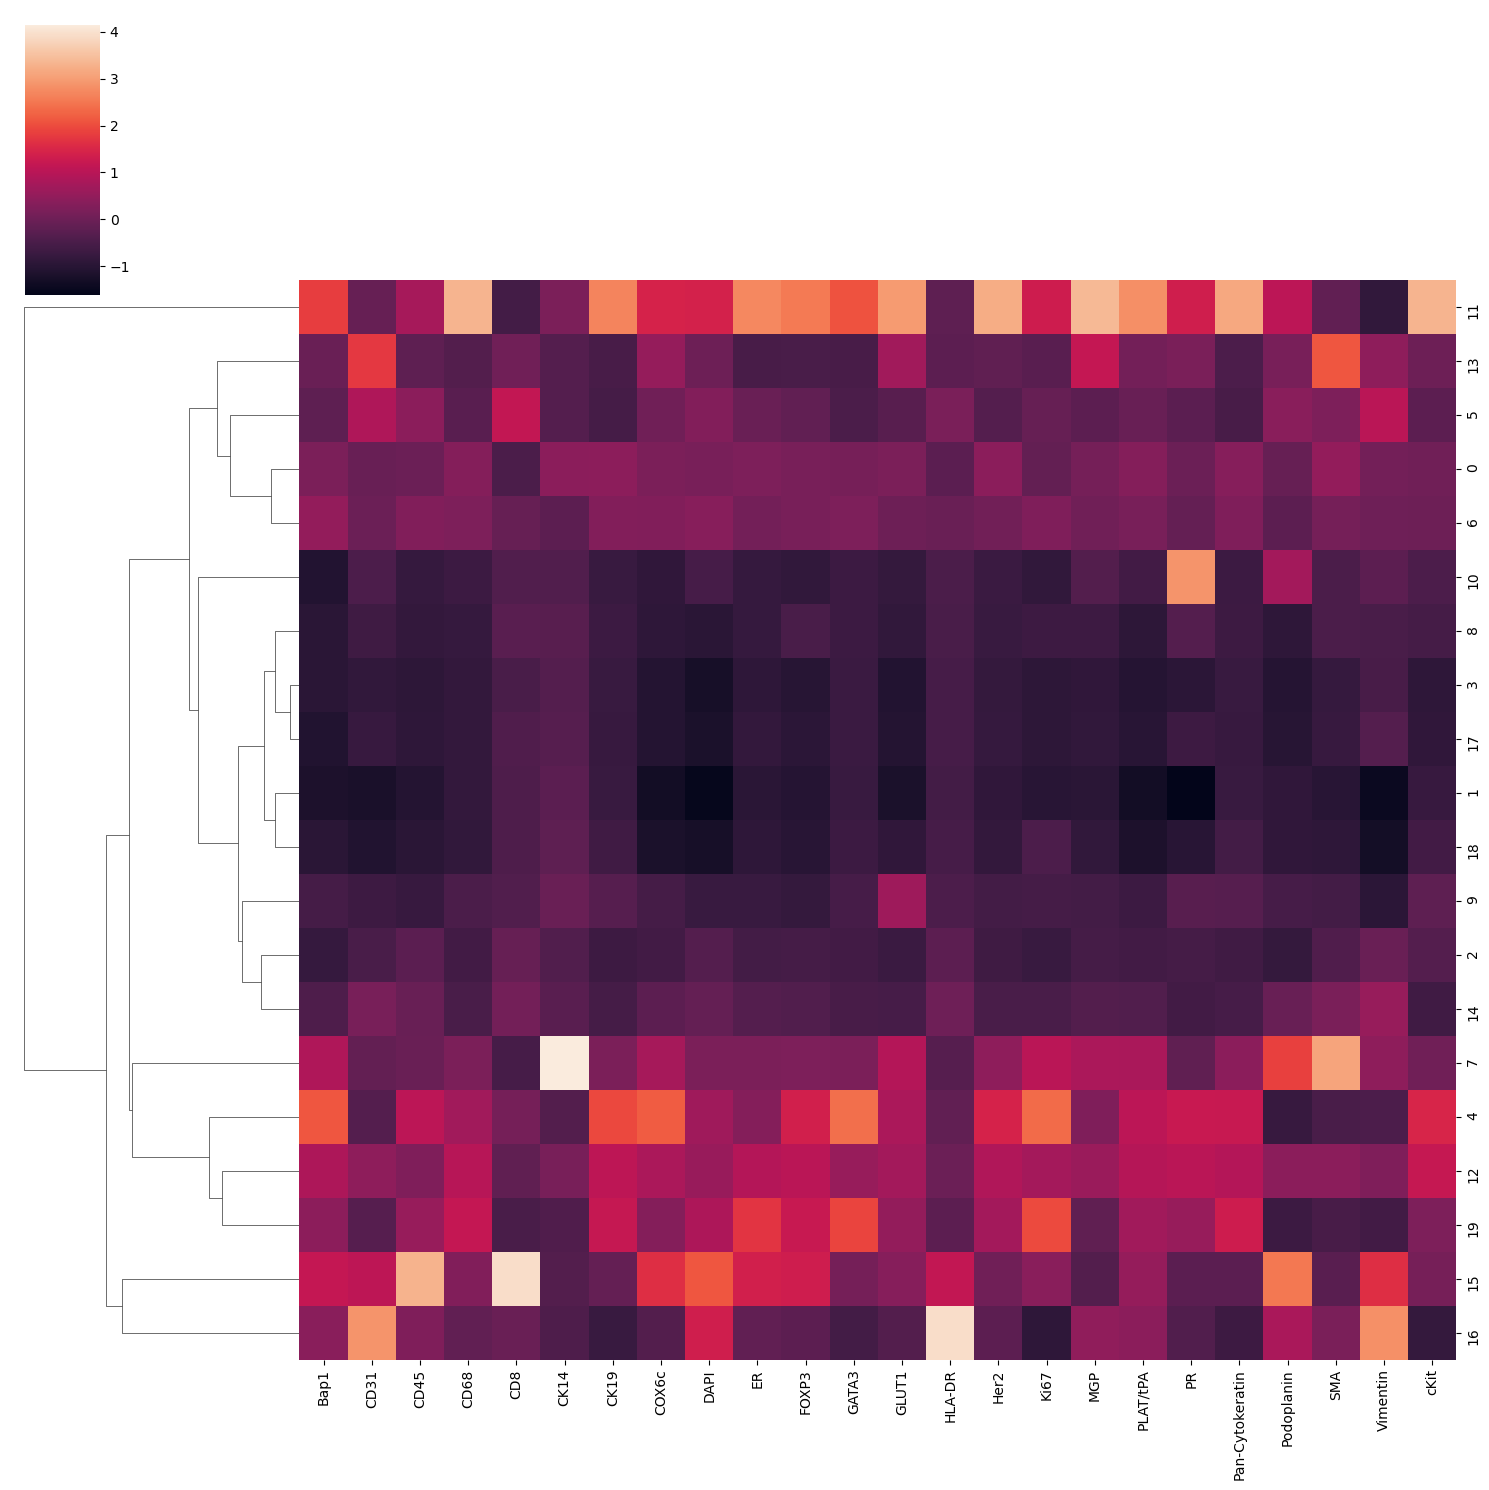

In [682]:
sns.clustermap(df, figsize=(15, 15), z_score=True, col_cluster=False)

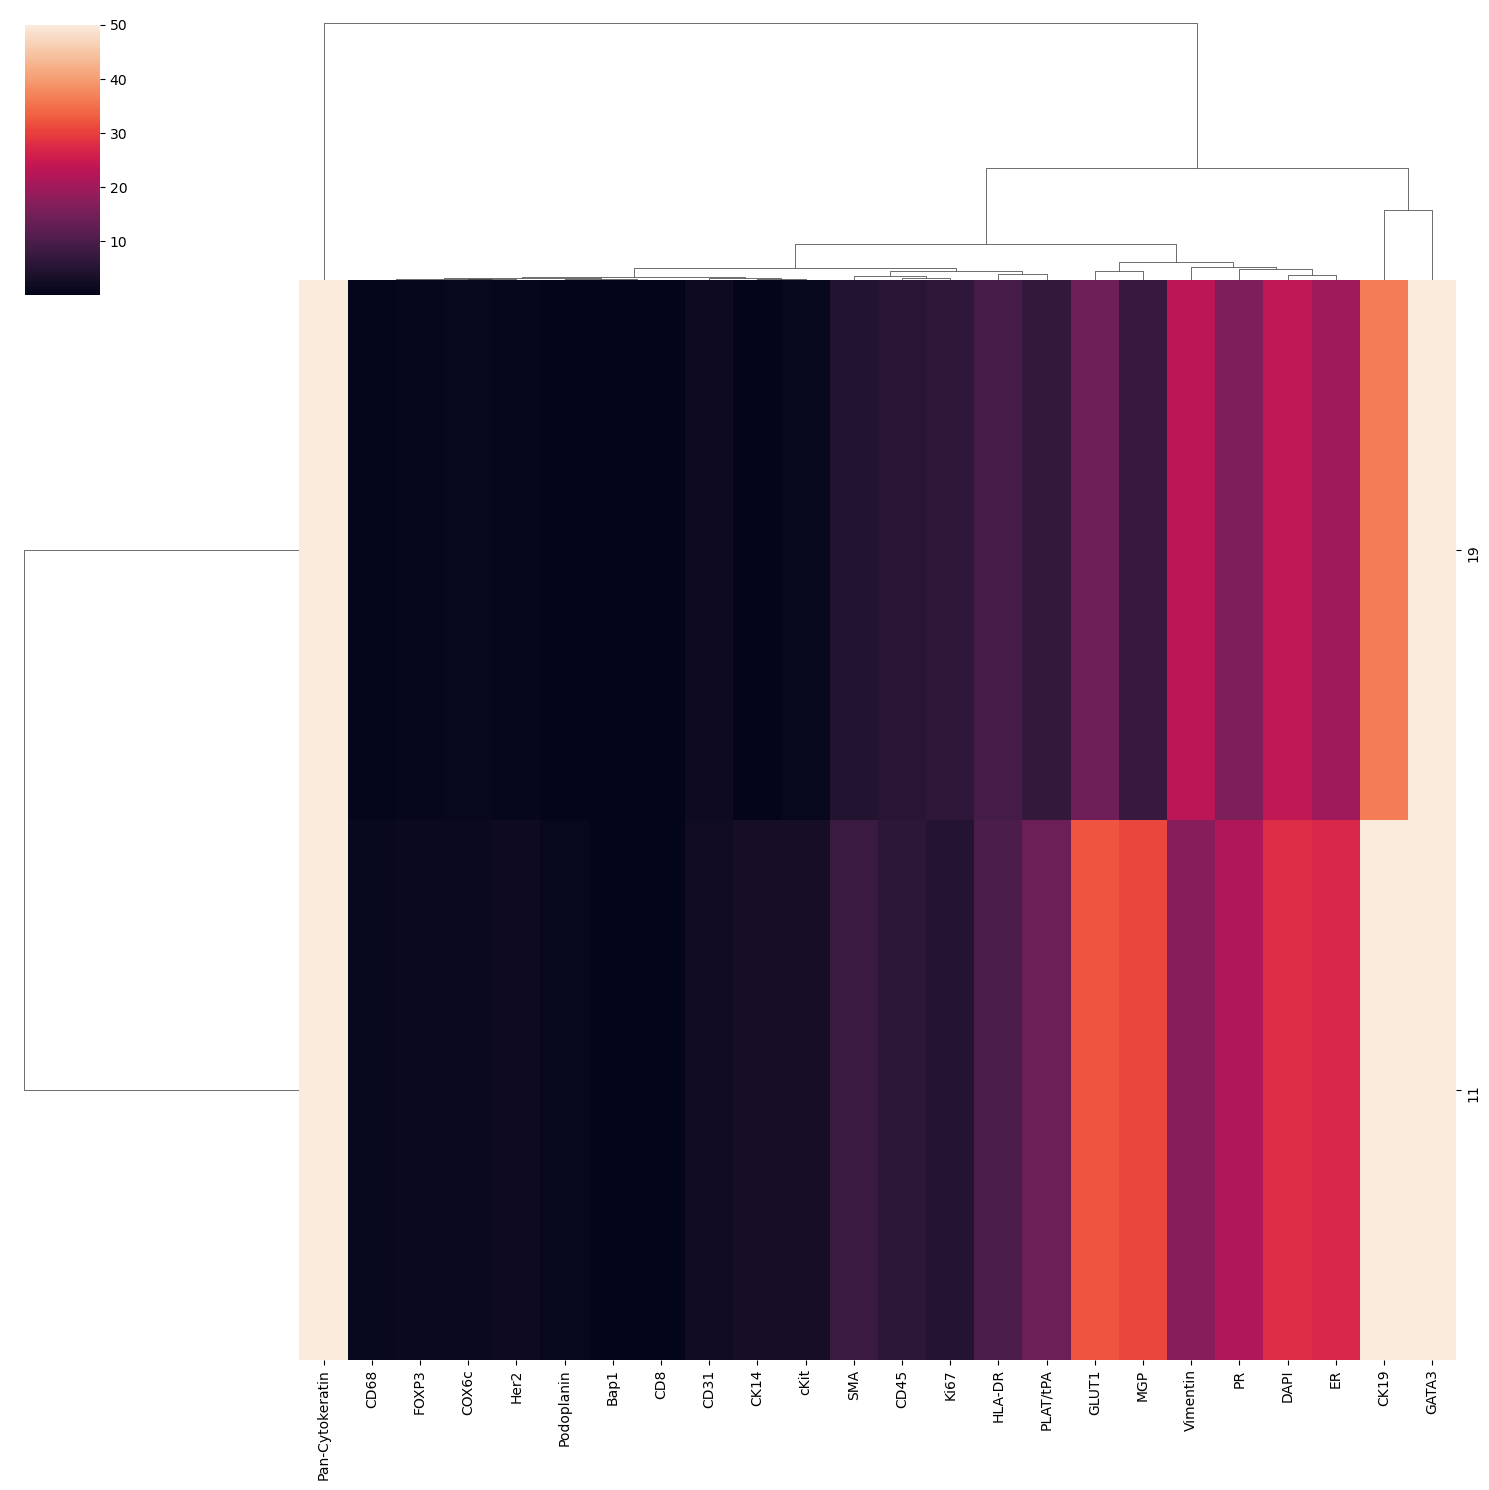

In [689]:
sns.clustermap(df.loc[[19, 11]], figsize=(15, 15), vmax=50)

In [724]:
for cluster in range(to_save.shape[1]):
    tifffile.imsave(f'../data/mae_v10/cluster_{cluster}.tif', to_save[:, cluster, :, :])